## Know your libraries (KYL)

In [1]:
import sys
sys.path.append('../../../src')

import multiprocessing as mp
mp.set_start_method('spawn', force=True)

import dataset, molecular_representation, config, utils, model
from dataset import QM9Dataset,LogSDataset,LogPDataset,FreeSolvDataset,ESOLDataset,ToxQDataset
import numpy as np
import pandas as pd
from utils import *
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, Subset
from scipy.stats import pearsonr
from tqdm import tqdm
from model import AtomAutoencoder,BondAutoencoder
from model import GNNBondAngle,GNN2D,GNN3D,GNN3DAtnON,GNN3DAtnOFF,GNN3Dihed,GNN3DConfig,GNN3DLayer,GNN3DClassifier

import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
IPythonConsole.drawOptions.addStereoAnnotation = True

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

import os
datadir="../../../data/regression/freesolv/"
modeldir="./models/"
dataset_name="freesolv"
# Create datadir and modeldir folders if they don't exist
if not os.path.exists(datadir):
    os.makedirs(datadir)

if not os.path.exists(modeldir):
    os.makedirs(modeldir)

import time
import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Split your dataset (SYD)

In [2]:
# Load dataset from CSV
dataset = pd.read_csv(datadir+dataset_name+".csv")

# Split dataset into train and test
train_dataset, test_dataset = split_dataset(dataset, 0.9)

# Write train_dataset and test_dataset to CSV files
train_dataset.to_csv(datadir+"train.csv", index=False)
test_dataset.to_csv(datadir+"test.csv", index=False)

print("Train and test datasets saved successfully.")

Train and test datasets saved successfully.


## Process your data (PYD)

In [3]:
train_samples = FreeSolvDataset(datadir+"train")
print(train_samples)
print("===================================")
test_samples = FreeSolvDataset(datadir+"test")
print(test_samples)

Loading dataset from folder
Initializing Molecular Representation Generator
Dataset Name: FreeSolv
Number of Molecules Loaded: 577
Loading dataset from folder
Initializing Molecular Representation Generator
Dataset Name: FreeSolv
Number of Molecules Loaded: 65


## Know your featues (KYF)

In [4]:
         """
         Convert SMILES to a molecule representation
         I.E A collection of the following vectors
             1. Atomic Feature Vectors
             2. Bond Feature Vectors
             3. Bond Indices
             4. Angle Feature Vectors
             5. Angle Indices
             6. Dihedral Feature Vectors
             7. Dihedral Indices 
             8. Global Molecular Features
         """

# Printing out the dimensions of all of these features with a description of what each feature is for a paticular molecule
print(f"Atomic Features:           {(train_samples[1])[0].shape} - This represents the atomic features of the molecule")
print(f"Bond Features:             {(train_samples[1])[1].shape} - This represents the bond features of the molecule")
print(f"Bond Indices:              {(train_samples[1])[2].shape} - This represents the bond indices of the molecule")
print(f"Angle Features:            {(train_samples[1])[3].shape} - This represents the angle features of the molecule")
print(f"Angle Indices:             {(train_samples[1])[4].shape} - This represents the angle indices of the molecule")
print(f"Dihedral Features:         {(train_samples[1])[5].shape} - This represents the dihedral features of the molecule")
print(f"Dihedral Indices:          {(train_samples[1])[6].shape} - This represents the dihedral indices of the molecule")
print(f"Global Molecular Features: {(train_samples[1])[7].shape} - This represents the global molecular features of the molecule")

print(f"Target: {(train_samples[0])[8].shape} - This represents the target of the molecule")

Atomic Features:           torch.Size([6, 154]) - This represents the atomic features of the molecule
Bond Features:             torch.Size([10, 10]) - This represents the bond features of the molecule
Bond Indices:              torch.Size([12]) - This represents the bond indices of the molecule
Angle Features:            torch.Size([8]) - This represents the angle features of the molecule
Angle Indices:             torch.Size([200]) - This represents the angle indices of the molecule
Dihedral Features:         torch.Size([10, 2]) - This represents the dihedral features of the molecule
Dihedral Indices:          torch.Size([12, 2]) - This represents the dihedral indices of the molecule
Global Molecular Features: torch.Size([8, 2]) - This represents the global molecular features of the molecule
Target: torch.Size([1]) - This represents the target of the molecule


## Know your correlations (KYC)

In [5]:
# Calculate R^2
def calculate_r_squared(predictions, targets):
    ss_tot = np.sum((targets - np.mean(targets))**2)
    ss_res = np.sum((targets - predictions)**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

## Know your modules (KYM)

In [6]:
class CustomMoleculeDataset(Dataset):
    """A custom dataset class to work DataLoader"""
    def __init__(self, samples, atom_autoencoder, bond_autoencoder, device):
        self.samples = samples
        self.atom_autoencoder = atom_autoencoder
        self.bond_autoencoder = bond_autoencoder
        self.device = device

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        processed_data = process_molecule(sample, self.atom_autoencoder, self.bond_autoencoder, self.device)

        if processed_data is None:
            return (None,) * 9

        if len(processed_data) != 9:
            raise ValueError(f"Unexpected number of elements: {len(processed_data)}")


        return processed_data




def process_molecule(molecule, atom_autoencoder, bond_autoencoder, device):
    """Separate input features and target"""
    if len(molecule) < 9:
        return None

    # Extracting features and target (9th element (index 8) is the target)
    target = molecule[8]
    molecule_data = [mol_elem for mol_elem in molecule[:8]]

    atom_features = molecule_data[0]
    bond_features = molecule_data[1]

    if len(atom_features) == 0 or len(bond_features) == 0:
        return None

   #molecule_data = [item.to(device) for item in molecule_data]
    molecule_data = [item.to(device).detach() for item in molecule_data]
    # Applying encoders
    molecule_data[0] = atom_autoencoder.encode(molecule_data[0])
    molecule_data[1] = bond_autoencoder.encode(molecule_data[1])


    # Moving data to the device in the training loop
    return molecule_data[0], molecule_data[1], molecule_data[2], molecule_data[3], molecule_data[4], molecule_data[5], molecule_data[6], molecule_data[7], target




def collate_fn(batch):
    """Custom collate function for batching molecular data."""


    # Filter out None values
    batch = [item for item in batch if item[0] is not None]

    # If all samples were skipped, return empty tensors
    if not batch:
        return (torch.empty(0),) * 8 + (torch.empty(0),)

    # Extract components from batch
    atomic_features = [item[0] for item in batch]
    bond_features = [item[1] for item in batch]
    angle_features = [item[2] for item in batch]
    dihedral_features = [item[3] for item in batch]
    global_molecular_features = [item[4] for item in batch]
    bond_indices = [item[5] for item in batch]
    angle_indices = [item[6] for item in batch]
    dihedral_indices = [item[7] for item in batch]
    targets = [item[8] for item in batch]

    # Determine the device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Convert all tensors to detach and ensure they are on the same device
    def detach_and_to_device(tensors, device):
        return [tensor.detach().to(device) for tensor in tensors]

    device = atomic_features[0].device if atomic_features else 'cpu'
    atomic_features = detach_and_to_device(atomic_features, device)
    bond_features = detach_and_to_device(bond_features, device)
    angle_features = detach_and_to_device(angle_features, device)
    dihedral_features = detach_and_to_device(dihedral_features, device)
    global_molecular_features = detach_and_to_device(global_molecular_features, device)
    targets = detach_and_to_device(targets, device)

    # Pad sequences and stack
    def pad_sequences(sequences):
        lengths = [seq.size(0) for seq in sequences]
        max_len = max(lengths, default=0)
        return pad_sequence(sequences, batch_first=True, padding_value=0), max_len

    atomic_features, _ = pad_sequences(atomic_features)
    bond_features, max_bond_len = pad_sequences(bond_features)
    angle_features, max_angle_len = pad_sequences(angle_features)
    dihedral_features, max_dihedral_len = pad_sequences(dihedral_features)
    global_molecular_features = torch.stack(global_molecular_features)
    targets = torch.stack(targets)

    # Pad indices
    def pad_indices(indices_list, max_len):
        padded_indices = torch.full((len(indices_list), max_len, 2), -1, dtype=torch.long)
        for i, indices in enumerate(indices_list):
            if indices.size(0) > 0:
                end = min(indices.size(0), max_len)
                padded_indices[i, :end] = indices[:end]
        return padded_indices

    bond_indices = pad_indices(bond_indices, max_bond_len)
    angle_indices = pad_indices(angle_indices, max_angle_len)
    dihedral_indices = pad_indices(dihedral_indices, max_dihedral_len)

    # Create a batch and move to device
    batch_tensors = (
        atomic_features, bond_features, angle_features, dihedral_features,
        global_molecular_features, bond_indices, angle_indices, dihedral_indices,
        targets
    )

    # Move all tensors to the device
    batch_tensors = tuple(tensor.to(device) for tensor in batch_tensors)

    return batch_tensors
   #return atomic_features, bond_features, angle_features, dihedral_features, global_molecular_features, bond_indices, angle_indices, dihedral_indices, targets




def train_gnn3d_model(gnn3d, train_samples, val_samples, test_samples, atom_autoencoder, bond_autoencoder, n_epochs=10, printstep=10, save_dir="./models/", dataset_name="logs", batch_size=16, prefetch_factor=2, num_workers=0):
    """Train GNN3D"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    os.makedirs(save_dir, exist_ok=True)
    mse_loss_fn = torch.nn.MSELoss()
    gnn_optimizer = torch.optim.Adam(gnn3d.parameters(), lr=1e-3)

    dataloader_train = DataLoader(
        CustomMoleculeDataset(train_samples, atom_autoencoder, bond_autoencoder, device=device),
        batch_size=batch_size,
        prefetch_factor=prefetch_factor,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=False,
        collate_fn=collate_fn
    )

    dataloader_val = DataLoader(
        CustomMoleculeDataset(val_samples, atom_autoencoder, bond_autoencoder, device=device),
        batch_size=batch_size,
        prefetch_factor=prefetch_factor,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=False,
        collate_fn=collate_fn
    )

    dataloader_test = DataLoader(
        CustomMoleculeDataset(test_samples, atom_autoencoder, bond_autoencoder, device=device),
        batch_size=batch_size,
        prefetch_factor=prefetch_factor,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=False,
        collate_fn=collate_fn
    )

    gnn3d.to(device)
    start_time = time.time()

    avg_rmse_losses_train = []
    avg_mse_losses_train = []
    avg_rmse_losses_val = []
    avg_mse_losses_val = []

    for epoch_i in range(n_epochs):
        # Training
        avg_rmse_loss_train = 0
        avg_mse_loss_train = 0
        total_samples_train = 0
        skipped_samples_train = 0

        for batch in tqdm(dataloader_train, desc='Training samples'):


            # Filter out None values
            batch = [item for item in batch if item is not None]
            if not batch:
                skipped_samples_train += len(batch)
                continue

            atomic_features, bond_features, angle_features, dihedral_features, global_molecular_features, bond_indices, angle_indices, dihedral_indices, targets = batch


            valid_indices = [i for i, target in enumerate(targets) if target is not None]
            if not valid_indices:
                skipped_samples_train += len(targets)
                continue
            # Only retain valid samples
            atomic_features = atomic_features[valid_indices]
            bond_features = bond_features[valid_indices]
            angle_features = angle_features[valid_indices]
            dihedral_features = dihedral_features[valid_indices]
            global_molecular_features = global_molecular_features[valid_indices]
            bond_indices = bond_indices[valid_indices]
            angle_indices = angle_indices[valid_indices]
            dihedral_indices = dihedral_indices[valid_indices]
            targets = targets[valid_indices]


            # Forward pass
            total_loss = 0
            for i in range(len(targets)):
                molecule_data = (atomic_features[i], bond_features[i], angle_features[i], dihedral_features[i], global_molecular_features[i], bond_indices[i], angle_indices[i], dihedral_indices[i])
                #molecule_data = (atomic_features[i], bond_features[i], global_molecular_features[i], bond_indices[i])  #2D
                target = targets[i]

                prediction = gnn3d(molecule_data)
                loss = mse_loss_fn(prediction, target)
                total_loss += loss

#           total_loss /= len(targets)

            if len(targets) > 0:
                total_loss /= len(targets)
            else:
                continue  # Safeguard against division by zero


            gnn_optimizer.zero_grad()
            total_loss.backward()
            gnn_optimizer.step()

            avg_mse_loss_train += total_loss.item() * len(targets)
            avg_rmse_loss_train += torch.sqrt(total_loss).item() * len(targets)
            total_samples_train += len(targets)

        avg_mse_loss_train /= total_samples_train
        avg_rmse_loss_train /= total_samples_train
        avg_mse_losses_train.append(avg_mse_loss_train)
        avg_rmse_losses_train.append(avg_rmse_loss_train)


        # Validation
        avg_rmse_loss_val = 0
        avg_mse_loss_val = 0
        total_samples_val = 0
        skipped_samples_val = 0

        with torch.no_grad():
            for batch in tqdm(dataloader_val, desc='Validation samples'):

                # Filter out None values
                batch = [item for item in batch if item is not None]
                if not batch:
                    skipped_samples_val += len(batch)
                    continue

                atomic_features, bond_features, angle_features, dihedral_features, global_molecular_features, bond_indices, angle_indices, dihedral_indices, targets = batch

                valid_indices = [i for i, target in enumerate(targets) if target is not None]
                if not valid_indices:
                    skipped_samples_val += len(targets)
                    continue
                # Only retain valid samples
                atomic_features = atomic_features[valid_indices]
                bond_features = bond_features[valid_indices]
                angle_features = angle_features[valid_indices]
                dihedral_features = dihedral_features[valid_indices]
                global_molecular_features = global_molecular_features[valid_indices]
                bond_indices = bond_indices[valid_indices]
                angle_indices = angle_indices[valid_indices]
                dihedral_indices = dihedral_indices[valid_indices]
                targets = targets[valid_indices]

                # Forward pass
                total_loss = 0
                for i in range(len(targets)):
                    molecule_data = (atomic_features[i], bond_features[i], angle_features[i], dihedral_features[i], global_molecular_features[i], bond_indices[i], angle_indices[i], dihedral_indices[i])
                    #molecule_data = (atomic_features[i], bond_features[i], global_molecular_features[i], bond_indices[i])  #2D
                    target = targets[i]

                    prediction = gnn3d(molecule_data)
                    loss = mse_loss_fn(prediction, target)
                    total_loss += loss

#               total_loss /= len(targets)

                if len(targets) > 0:
                    total_loss /= len(targets)
                else:
                    continue  # Safeguard against division by zero


                avg_mse_loss_val += total_loss.item() * len(targets)
                avg_rmse_loss_val += torch.sqrt(total_loss).item() * len(targets)
                total_samples_val += len(targets)

        avg_mse_loss_val /= total_samples_val
        avg_rmse_loss_val /= total_samples_val
        avg_mse_losses_val.append(avg_mse_loss_val)
        avg_rmse_losses_val.append(avg_rmse_loss_val)

       #if epoch_i % printstep == 0 or epoch_i == n_epochs - 1:
        print(f"Epoch: {epoch_i:>3} | RMSE Train  Loss: {avg_rmse_loss_train:.4f} | MSE Train Loss: {avg_mse_loss_train:.4f} | RMSE Val  Loss: {avg_rmse_loss_val:.4f} | MSE Val Loss: {avg_mse_loss_val:.4f}")

    # Saving model state
    torch.save(gnn3d.state_dict(), os.path.join(save_dir, f"gnn3d_{dataset_name}.pth"))
    print(f"Model saved to {os.path.join(save_dir, f'gnn3d_{dataset_name}.pth')}")

    end_time = time.time()
    actual_time = end_time - start_time

    actual_time_td = datetime.timedelta(seconds=actual_time)
    hours = actual_time_td.seconds // 3600
    minutes = (actual_time_td.seconds // 60) % 60
    seconds = actual_time_td.seconds % 60
    actual_time_str = f"{hours} hours, {minutes} minutes, {seconds} seconds"

    print(f"Time taken for training: {actual_time_str}")

    # Evaluation on test samples
    avg_rmse_loss_test = 0
    avg_mse_loss_test = 0
    total_samples_test = 0
    skipped_samples_test = 0
    predictions = []
    targets = []

    with torch.no_grad():
        for batch in tqdm(dataloader_test, desc='Test samples'):

            # Filter out None values
            batch = [item for item in batch if item is not None]
            if not batch:
                skipped_samples_test += len(batch)
                continue

            atomic_features, bond_features, angle_features, dihedral_features, global_molecular_features, bond_indices, angle_indices, dihedral_indices, targets_batch = batch

            valid_indices = [i for i, target in enumerate(targets_batch) if target is not None]
            if not valid_indices:
                skipped_samples_test += len(targets_batch)
                continue
            # Only retain valid samples
            atomic_features = atomic_features[valid_indices]
            bond_features = bond_features[valid_indices]
            angle_features = angle_features[valid_indices]
            dihedral_features = dihedral_features[valid_indices]
            global_molecular_features = global_molecular_features[valid_indices]
            bond_indices = bond_indices[valid_indices]
            angle_indices = angle_indices[valid_indices]
            dihedral_indices = dihedral_indices[valid_indices]
            targets_batch = targets_batch[valid_indices]

            # Forward pass
            for i in range(len(targets_batch)):
                molecule_data = (atomic_features[i], bond_features[i], angle_features[i], dihedral_features[i], global_molecular_features[i], bond_indices[i], angle_indices[i], dihedral_indices[i])
                #molecule_data = (atomic_features[i], bond_features[i], global_molecular_features[i], bond_indices[i])  #2D
                target = targets_batch[i]

                prediction = gnn3d(molecule_data)
                loss = mse_loss_fn(prediction, target)

                # Extract target and prediction values
                predictions.append(prediction.item())
                targets.append(target.item())

                avg_mse_loss_test += loss.item()
                avg_rmse_loss_test += torch.sqrt(loss).item()
                total_samples_test += 1

    # Calculate average losses for test
    avg_mse_loss_test /= total_samples_test
    avg_rmse_loss_test /= total_samples_test

    print(f"Test Results:")
    print(f"RMSE Loss: {avg_rmse_loss_test:.4f}")
    print(f"MSE Loss: {avg_mse_loss_test:.4f}")

    end_time = time.time()
    actual_time = end_time - start_time

    actual_time_td = datetime.timedelta(seconds=actual_time)
    hours = actual_time_td.seconds // 3600
    minutes = (actual_time_td.seconds // 60) % 60
    seconds = actual_time_td.seconds % 60
    actual_time_str = f"{hours} hours, {minutes} minutes, {seconds} seconds"

    print(f"Time taken for training and evaluation: {actual_time_str}")

    return avg_rmse_losses_train, avg_mse_losses_train, avg_rmse_losses_val, avg_mse_losses_val, predictions, targets, skipped_samples_train, skipped_samples_val, skipped_samples_test

## Know your variables for main()

In [9]:
def main():
    """Function for train, validation and test
       Make sure to assign your local variables here too"""
    mp.set_start_method('spawn', force=True)

    datadir="../../../data/regression/freesolv/"
    modeldir="./models/"
    dataset_name="freesolv"

    train_samples = FreeSolvDataset(datadir+"train")
    print(train_samples)
    print("===================================")
    test_samples = FreeSolvDataset(datadir+"test")
    print(test_samples)
    print("===================================")

    n_epochs=10
    printstep=2
    batch_size=1
    prefetch_factor=None
    num_workers=0

    rmse_losses_train = []
    rmse_losses_val = []

    random_state_values = [98, 123, 456, 1704, 19472]

    for random_state in random_state_values:

        print(f"Training for random_state = {random_state}")

        gnn3d = GNN3Dihed(atomic_vector_size=10, bond_vector_size=3, number_of_molecular_features=200, number_of_targets=1).to(device)
        train_part_samples, val_samples = train_test_split(train_samples, test_size=0.1, random_state=random_state)
        atom_autoencoder = AtomAutoencoder(154, 10).to(device)
        bond_autoencoder = BondAutoencoder(10, 3).to(device)

        rmse_losses_train_per_model, mse_losses_train_per_model, rmse_losses_val_per_model, mse_losses_val_per_model, predictions, targets, skipped_train, skipped_val, skipped_test=train_gnn3d_model(
            gnn3d,
            train_part_samples,
            val_samples,
            test_samples,
            atom_autoencoder,
            bond_autoencoder,
            n_epochs=n_epochs,
            printstep=printstep,
            save_dir=modeldir,
            dataset_name=dataset_name,
            batch_size=batch_size,
            prefetch_factor=prefetch_factor,
            num_workers=num_workers
        )

        rmse_losses_train.append(rmse_losses_train_per_model)
        rmse_losses_val.append(rmse_losses_val_per_model)

    return gnn3d, atom_autoencoder, bond_autoencoder, n_epochs, rmse_losses_train, rmse_losses_val, predictions, targets

## Training=================================================
## GNN3D training for multiple models; and testing

Loading dataset from folder
Initializing Molecular Representation Generator
Dataset Name: FreeSolv
Number of Molecules Loaded: 577
Loading dataset from folder
Initializing Molecular Representation Generator
Dataset Name: FreeSolv
Number of Molecules Loaded: 65
Training for random_state = 98


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 463.00it/s]


Epoch:   0 | RMSE Train  Loss: 2.4561 | MSE Train Loss: 12.0459 | RMSE Val  Loss: 2.0661 | MSE Val Loss: 10.4276


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 485.72it/s]


Epoch:   1 | RMSE Train  Loss: 1.5742 | MSE Train Loss: 5.5336 | RMSE Val  Loss: 1.5479 | MSE Val Loss: 6.1270


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 481.22it/s]


Epoch:   2 | RMSE Train  Loss: 1.2343 | MSE Train Loss: 3.4272 | RMSE Val  Loss: 1.4950 | MSE Val Loss: 4.2260


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 490.43it/s]


Epoch:   3 | RMSE Train  Loss: 1.0474 | MSE Train Loss: 2.4112 | RMSE Val  Loss: 1.4274 | MSE Val Loss: 3.8883


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 506.90it/s]


Epoch:   4 | RMSE Train  Loss: 0.9637 | MSE Train Loss: 2.1037 | RMSE Val  Loss: 1.2040 | MSE Val Loss: 2.9387


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 484.53it/s]


Epoch:   5 | RMSE Train  Loss: 0.8803 | MSE Train Loss: 1.7426 | RMSE Val  Loss: 1.1326 | MSE Val Loss: 2.5638


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 483.91it/s]


Epoch:   6 | RMSE Train  Loss: 0.8416 | MSE Train Loss: 1.5653 | RMSE Val  Loss: 1.4021 | MSE Val Loss: 3.3520


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 506.58it/s]


Epoch:   7 | RMSE Train  Loss: 0.8348 | MSE Train Loss: 1.5146 | RMSE Val  Loss: 1.1549 | MSE Val Loss: 2.8121


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 496.66it/s]


Epoch:   8 | RMSE Train  Loss: 0.7981 | MSE Train Loss: 1.3593 | RMSE Val  Loss: 1.0757 | MSE Val Loss: 2.4478


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 515.24it/s]


Epoch:   9 | RMSE Train  Loss: 0.7825 | MSE Train Loss: 1.3339 | RMSE Val  Loss: 1.0757 | MSE Val Loss: 2.5898
Model saved to ./models/gnn3d_freesolv.pth
Time taken for training: 0 hours, 0 minutes, 31 seconds


Test samples: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 458.13it/s]


Test Results:
RMSE Loss: 0.9173
MSE Loss: 1.9685
Time taken for training and evaluation: 0 hours, 0 minutes, 31 seconds
Training for random_state = 123


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 508.08it/s]


Epoch:   0 | RMSE Train  Loss: 2.3305 | MSE Train Loss: 11.3276 | RMSE Val  Loss: 1.6830 | MSE Val Loss: 4.8923


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 505.25it/s]


Epoch:   1 | RMSE Train  Loss: 1.4543 | MSE Train Loss: 4.7353 | RMSE Val  Loss: 1.9314 | MSE Val Loss: 5.8110


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 478.19it/s]


Epoch:   2 | RMSE Train  Loss: 1.1285 | MSE Train Loss: 2.7628 | RMSE Val  Loss: 1.2152 | MSE Val Loss: 2.9397


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 459.49it/s]


Epoch:   3 | RMSE Train  Loss: 0.9908 | MSE Train Loss: 1.9839 | RMSE Val  Loss: 1.2169 | MSE Val Loss: 2.8232


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 484.57it/s]


Epoch:   4 | RMSE Train  Loss: 0.9049 | MSE Train Loss: 1.6605 | RMSE Val  Loss: 1.1734 | MSE Val Loss: 2.8406


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 500.14it/s]


Epoch:   5 | RMSE Train  Loss: 0.8468 | MSE Train Loss: 1.4963 | RMSE Val  Loss: 1.1249 | MSE Val Loss: 2.7903


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 464.64it/s]


Epoch:   6 | RMSE Train  Loss: 0.7965 | MSE Train Loss: 1.3112 | RMSE Val  Loss: 1.1333 | MSE Val Loss: 2.6616


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 533.14it/s]


Epoch:   7 | RMSE Train  Loss: 0.7780 | MSE Train Loss: 1.2751 | RMSE Val  Loss: 1.1450 | MSE Val Loss: 2.9156


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 503.47it/s]


Epoch:   8 | RMSE Train  Loss: 0.7728 | MSE Train Loss: 1.1631 | RMSE Val  Loss: 1.1486 | MSE Val Loss: 3.0586


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 513.48it/s]


Epoch:   9 | RMSE Train  Loss: 0.7362 | MSE Train Loss: 1.0931 | RMSE Val  Loss: 1.3079 | MSE Val Loss: 3.4778
Model saved to ./models/gnn3d_freesolv.pth
Time taken for training: 0 hours, 0 minutes, 30 seconds


Test samples: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 510.03it/s]


Test Results:
RMSE Loss: 1.0643
MSE Loss: 2.4793
Time taken for training and evaluation: 0 hours, 0 minutes, 30 seconds
Training for random_state = 456


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 505.39it/s]


Epoch:   0 | RMSE Train  Loss: 2.3886 | MSE Train Loss: 11.3770 | RMSE Val  Loss: 1.3729 | MSE Val Loss: 3.2062


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 508.23it/s]


Epoch:   1 | RMSE Train  Loss: 1.4296 | MSE Train Loss: 4.5625 | RMSE Val  Loss: 0.9671 | MSE Val Loss: 1.5219


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 483.15it/s]


Epoch:   2 | RMSE Train  Loss: 1.1709 | MSE Train Loss: 2.8766 | RMSE Val  Loss: 0.9044 | MSE Val Loss: 1.4142


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 576.29it/s]


Epoch:   3 | RMSE Train  Loss: 1.0321 | MSE Train Loss: 2.2012 | RMSE Val  Loss: 0.8773 | MSE Val Loss: 1.3812


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 537.86it/s]


Epoch:   4 | RMSE Train  Loss: 0.9647 | MSE Train Loss: 1.8965 | RMSE Val  Loss: 0.9044 | MSE Val Loss: 1.3050


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 530.19it/s]


Epoch:   5 | RMSE Train  Loss: 0.8997 | MSE Train Loss: 1.6715 | RMSE Val  Loss: 0.9781 | MSE Val Loss: 1.6569


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 574.60it/s]


Epoch:   6 | RMSE Train  Loss: 0.8699 | MSE Train Loss: 1.5499 | RMSE Val  Loss: 0.8740 | MSE Val Loss: 1.2713


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 550.01it/s]


Epoch:   7 | RMSE Train  Loss: 0.8799 | MSE Train Loss: 1.5149 | RMSE Val  Loss: 0.8628 | MSE Val Loss: 1.2857


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 512.54it/s]


Epoch:   8 | RMSE Train  Loss: 0.8571 | MSE Train Loss: 1.4014 | RMSE Val  Loss: 0.8209 | MSE Val Loss: 1.1148


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 525.12it/s]


Epoch:   9 | RMSE Train  Loss: 0.8466 | MSE Train Loss: 1.3413 | RMSE Val  Loss: 0.8127 | MSE Val Loss: 1.1281
Model saved to ./models/gnn3d_freesolv.pth
Time taken for training: 0 hours, 0 minutes, 30 seconds


Test samples: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 521.68it/s]


Test Results:
RMSE Loss: 0.9168
MSE Loss: 1.8995
Time taken for training and evaluation: 0 hours, 0 minutes, 30 seconds
Training for random_state = 1704


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 544.05it/s]


Epoch:   0 | RMSE Train  Loss: 2.2865 | MSE Train Loss: 10.1851 | RMSE Val  Loss: 1.5183 | MSE Val Loss: 5.2852


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 542.20it/s]


Epoch:   1 | RMSE Train  Loss: 1.4168 | MSE Train Loss: 4.3544 | RMSE Val  Loss: 1.1930 | MSE Val Loss: 3.0710


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 538.29it/s]


Epoch:   2 | RMSE Train  Loss: 1.0939 | MSE Train Loss: 2.7036 | RMSE Val  Loss: 1.2002 | MSE Val Loss: 2.6592


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 526.90it/s]


Epoch:   3 | RMSE Train  Loss: 1.0008 | MSE Train Loss: 2.1115 | RMSE Val  Loss: 1.1278 | MSE Val Loss: 2.1133


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 522.90it/s]


Epoch:   4 | RMSE Train  Loss: 0.9625 | MSE Train Loss: 1.8297 | RMSE Val  Loss: 0.9346 | MSE Val Loss: 1.6179


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 558.75it/s]


Epoch:   5 | RMSE Train  Loss: 0.8996 | MSE Train Loss: 1.6732 | RMSE Val  Loss: 1.0609 | MSE Val Loss: 1.9140


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 518.38it/s]


Epoch:   6 | RMSE Train  Loss: 0.8589 | MSE Train Loss: 1.5166 | RMSE Val  Loss: 0.8828 | MSE Val Loss: 1.3993


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 555.29it/s]


Epoch:   7 | RMSE Train  Loss: 0.8318 | MSE Train Loss: 1.4435 | RMSE Val  Loss: 0.8993 | MSE Val Loss: 1.4839


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 532.75it/s]


Epoch:   8 | RMSE Train  Loss: 0.7956 | MSE Train Loss: 1.2925 | RMSE Val  Loss: 0.9284 | MSE Val Loss: 1.5397


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 545.58it/s]


Epoch:   9 | RMSE Train  Loss: 0.7851 | MSE Train Loss: 1.2513 | RMSE Val  Loss: 0.8113 | MSE Val Loss: 1.2946
Model saved to ./models/gnn3d_freesolv.pth
Time taken for training: 0 hours, 0 minutes, 29 seconds


Test samples: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 532.42it/s]


Test Results:
RMSE Loss: 0.9692
MSE Loss: 2.0519
Time taken for training and evaluation: 0 hours, 0 minutes, 29 seconds
Training for random_state = 19472


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 543.80it/s]


Epoch:   0 | RMSE Train  Loss: 2.4881 | MSE Train Loss: 12.0598 | RMSE Val  Loss: 1.7933 | MSE Val Loss: 6.6419


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 540.42it/s]


Epoch:   1 | RMSE Train  Loss: 1.4548 | MSE Train Loss: 4.9990 | RMSE Val  Loss: 1.2021 | MSE Val Loss: 3.0930


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 558.88it/s]


Epoch:   2 | RMSE Train  Loss: 1.1529 | MSE Train Loss: 3.0494 | RMSE Val  Loss: 1.1497 | MSE Val Loss: 2.3811


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 530.01it/s]


Epoch:   3 | RMSE Train  Loss: 1.0018 | MSE Train Loss: 2.2096 | RMSE Val  Loss: 1.2156 | MSE Val Loss: 2.4387


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 556.55it/s]


Epoch:   4 | RMSE Train  Loss: 0.9508 | MSE Train Loss: 1.9550 | RMSE Val  Loss: 1.1240 | MSE Val Loss: 2.1798


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 519.55it/s]


Epoch:   5 | RMSE Train  Loss: 0.9046 | MSE Train Loss: 1.6985 | RMSE Val  Loss: 1.4319 | MSE Val Loss: 2.8883


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 571.45it/s]


Epoch:   6 | RMSE Train  Loss: 0.8780 | MSE Train Loss: 1.5314 | RMSE Val  Loss: 0.9656 | MSE Val Loss: 1.7995


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 502.02it/s]


Epoch:   7 | RMSE Train  Loss: 0.8498 | MSE Train Loss: 1.4748 | RMSE Val  Loss: 1.0064 | MSE Val Loss: 1.8703


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 569.91it/s]


Epoch:   8 | RMSE Train  Loss: 0.8518 | MSE Train Loss: 1.3722 | RMSE Val  Loss: 0.9893 | MSE Val Loss: 1.8363


Validation samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 498.24it/s]


Epoch:   9 | RMSE Train  Loss: 0.8166 | MSE Train Loss: 1.3522 | RMSE Val  Loss: 0.9099 | MSE Val Loss: 1.6630
Model saved to ./models/gnn3d_freesolv.pth
Time taken for training: 0 hours, 0 minutes, 29 seconds


Test samples: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 511.66it/s]


Test Results:
RMSE Loss: 0.9667
MSE Loss: 2.1139
Time taken for training and evaluation: 0 hours, 0 minutes, 29 seconds
RMSE Losses Train: [[2.4560715003739433, 1.5741684625718406, 1.2342754088787216, 1.0474483888732675, 0.9636637924637409, 0.8803032447004364, 0.8415519931929649, 0.8347919044840313, 0.7981099285659073, 0.7824708464374203], [2.330503184097121, 1.4543295673207741, 1.128521088173394, 0.9907610515179203, 0.9049077810206395, 0.8468105664659786, 0.7965198347563918, 0.7780339536266061, 0.7728012998324598, 0.7362365728829178], [2.388618159902808, 1.4296261829706285, 1.170923802606862, 1.032136312454422, 0.9646613587749142, 0.8996693644105584, 0.8699276497684463, 0.8799124963165248, 0.8571289518636316, 0.8466341149829946], [2.2865472806901144, 1.4167765675683242, 1.0938658337171596, 1.0007895362314, 0.9624932467478089, 0.8996418339123157, 0.8588764604059028, 0.8317638463941842, 0.7955749094062745, 0.7850816358088988], [2.4880889947014735, 1.454844382636407, 1.1528725499190347, 

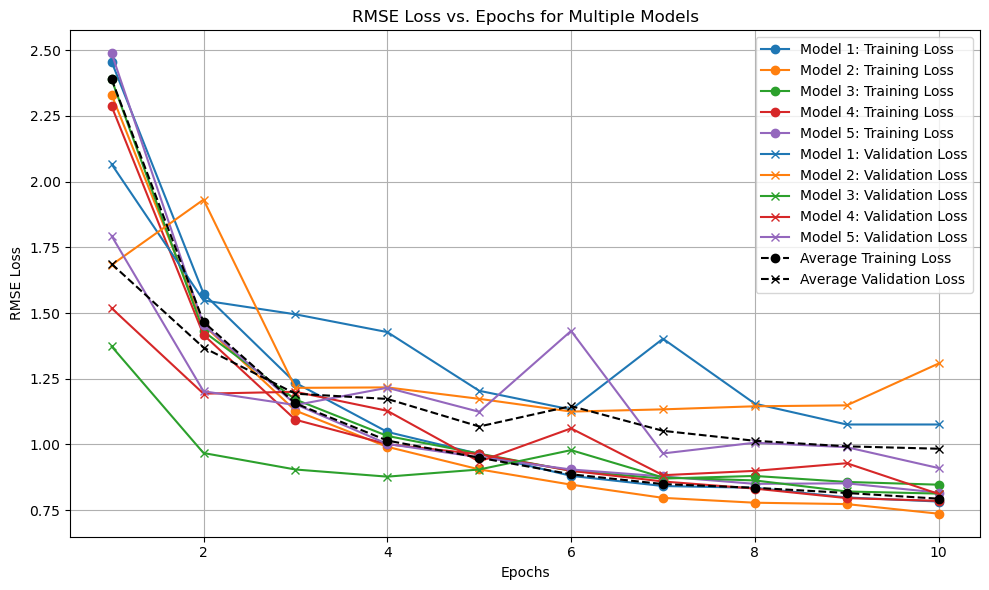

Epoch | Average Training Loss | Average Validation Loss
    0 | 2.3900                | 1.6867
    1 | 1.4659                | 1.3683
    2 | 1.1561                | 1.1929
    3 | 1.0146                | 1.1730
    4 | 0.9493                | 1.0681
    5 | 0.8862                | 1.1457
    6 | 0.8490                | 1.0516
    7 | 0.8349                | 1.0137
    8 | 0.8151                | 0.9926
    9 | 0.7934                | 0.9835
Pearson Correlation Coefficient: 0.9264
Coefficient of Determination R^2: 0.8499


In [10]:
if __name__ == '__main__':
    gnn3d, atom_autoencoder, bond_autoencoder, n_epochs, rmse_losses_train, rmse_losses_val, predictions, targets = main()

    print("RMSE Losses Train:", rmse_losses_train)
    print("RMSE Losses Val:", rmse_losses_val)

    plt.figure(figsize=(10, 6))
    for i, train_losses in enumerate(rmse_losses_train):
        plt.plot(range(1, n_epochs + 1), train_losses, marker='o', color=f'C{i}', label=f'Model {i+1}: Training Loss')

    for i, val_losses in enumerate(rmse_losses_val):
        plt.plot(range(1, n_epochs + 1), val_losses, marker='x', color=f'C{i}', label=f'Model {i+1}: Validation Loss')

    # Calculate and plot average losses for training and validation from various models
    avg_train_losses = [sum(losses) / len(losses) for losses in zip(*rmse_losses_train)]
    avg_val_losses = [sum(losses) / len(losses) for losses in zip(*rmse_losses_val)]

    plt.plot(range(1, n_epochs + 1), avg_train_losses, marker='o', color='black', linestyle='--', label='Average Training Loss')
    plt.plot(range(1, n_epochs + 1), avg_val_losses, marker='x', color='black', linestyle='--', label='Average Validation Loss')

    plt.xlabel('Epochs')
    plt.ylabel('RMSE Loss')
    plt.title('RMSE Loss vs. Epochs for Multiple Models')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{modeldir}gnn3d_losses_{dataset_name}_multi_models.png")
    plt.savefig(f"{modeldir}gnn3d_losses_{dataset_name}_multi_models.svg", format='svg')
    plt.show()

    print(f"Epoch | Average Training Loss | Average Validation Loss")
    for i in range(n_epochs):
        print(f" {i:>4} | {avg_train_losses[i]:.4f}                | {avg_val_losses[i]:.4f}")

## Know your correlations (KYC)=============================

    # Convert lists to NumPy arrays
    predictions = np.array(predictions)
    targets = np.array(targets)

    # Calculate Pearson correlation coefficient
    corr, _ = pearsonr(predictions, targets)

    print(f"Pearson Correlation Coefficient: {corr:.4f}")

    r_squared = calculate_r_squared(predictions, targets)
    print(f"Coefficient of Determination R^2: {r_squared:.4f}")